<a href="https://colab.research.google.com/github/christophersingh/Mental-Health-Classification-Research-/blob/main/Copy_of_Clustering_With_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#read in the data
ny = pd.read_csv('./new_york.csv')
ny

,indicator,group,state,subgroup,phase,time_period,time_period_label,time_period_start_date,time_period_end_date,value,lowci,highci,confidence_interval,quartile_range,age,CASE_RATE,HOSPITALIZED_RATE,DEATH_RATE,date,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,counts,sentiment__negative,sentiment__positive
0,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,171.46,13.55,0.23,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
1,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,1554.45,153.69,12.88,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
2,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,2529.03,630.34,113.37,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
3,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,2552.64,1192.50,364.17,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
4,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,2976.74,1830.07,909.18,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35779,Symptoms of Anxiety Disorder or Depressive Dis...,By State,New York,New York,3 (Jan 6 � Feb 1),23.0,Jan 20 - Feb 1,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,32.0 - 39.7,28.8-37.6,80 years and above,20207.72,1160.60,67.68,2021-02-01,224684.00000,13326.000000,794.000000,419169.0,501.0,49.0
35780,Symptoms of Anxiety Disorder or Depressive Dis...,By State,New York,New York,3 (Jan 6 � Feb 1),23.0,Jan 20 - Feb 1,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,32.0 - 39.7,28.8-37.6,80 years and above,15941.19,2540.10,476.51,2021-02-01,161559.00000,25652.000000,4800.000000,419169.0,501.0,49.0
35781,Symptoms of Anxiety Disorder or Depressive Dis...,By State,New York,New York,3 (Jan 6 � Feb 1),23.0,Jan 20 - Feb 1,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,32.0 - 39.7,28.8-37.6,80 years and above,7067.11,2418.35,756.82,2021-02-01,50798.00000,17383.000000,5440.000000,419169.0,501.0,49.0
35782,Symptoms of Anxiety Disorder or Depressive Dis...,By State,New York,New York,3 (Jan 6 � Feb 1),23.0,Jan 20 - Feb 1,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,32.0 - 39.7,28.8-37.6,80 years and above,7477.43,3995.12,1989.81,2021-02-01,41994.00000,22437.000000,11175.000000,419169.0,501.0,49.0


In [ ]:
ny["indicator"].replace({"Symptoms of Anxiety Disorder": "0", "Symptoms of Depressive Disorder": "1", "Symptoms of Anxiety Disorder or Depressive Disorder": "2"}, inplace=True)
ny["age"].replace({"18 - 29 years": "29", "30 - 39 years": "39", "40 - 49 years": "49", "50 - 59 years":"59","60 - 69 years":"69","70 - 79 years":"79","80 years and above":"80"}, inplace=True)

data_to_use = ny
del data_to_use['group']
del data_to_use['state']
del data_to_use['subgroup']
del data_to_use['time_period_label']
del data_to_use['confidence_interval']
del data_to_use['quartile_range']
del data_to_use['counts']

ny = data_to_use
ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35784 entries, 0 to 35783
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   indicator               35784 non-null  object 
 1   phase                   35784 non-null  object 
 2   time_period             35784 non-null  float64
 3   time_period_start_date  35784 non-null  object 
 4   time_period_end_date    35784 non-null  object 
 5   value                   35784 non-null  float64
 6   lowci                   35784 non-null  float64
 7   highci                  35784 non-null  float64
 8   age                     35784 non-null  object 
 9   CASE_RATE               35784 non-null  float64
 10  HOSPITALIZED_RATE       35784 non-null  float64
 11  DEATH_RATE              33957 non-null  float64
 12  date                    35784 non-null  object 
 13  CASE_COUNT              35784 non-null  float64
 14  HOSPITALIZED_COUNT      35784 non-null

In [ ]:
ny['DEATH_RATE'].fillna((ny['DEATH_RATE'].mean()), inplace=True)
ny.isna().sum()

indicator                 0
phase                     0
time_period               0
time_period_start_date    0
time_period_end_date      0
value                     0
lowci                     0
highci                    0
age                       0
CASE_RATE                 0
HOSPITALIZED_RATE         0
DEATH_RATE                0
date                      0
CASE_COUNT                0
HOSPITALIZED_COUNT        0
DEATH_COUNT               0
sentiment__negative       0
sentiment__positive       0
dtype: int64

In [ ]:
#Add this cell after API change
ny.loc[ny['phase'] == ('Oct 28 � Dec 21'), 'phase'] = 3
ny.loc[ny['phase'] == ('3 (Oct 28 � Dec 21)'), 'phase'] = 4
ny.loc[ny['phase'] == ('3 (Jan 6 � Feb 1)'), 'phase'] = 5
ny.rename(columns = {'counts':'twitter_count'}, inplace = True)

In [ ]:
from sklearn import preprocessing

ny["age"] = ny['age'].astype(float)
ny["phase"] = ny['phase'].astype(float)
ny["indicator"] = ny['indicator'].astype(float)
ny["time_period"] = ny['time_period'].astype(float)

"""def min_max_normalization(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

ny = min_max_normalization(data_to_use)"""
ny

,indicator,phase,time_period,time_period_start_date,time_period_end_date,value,lowci,highci,age,CASE_RATE,HOSPITALIZED_RATE,DEATH_RATE,date,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,sentiment__negative,sentiment__positive
0,1.0,1.0,1.0,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,29.0,171.46,13.55,0.23,2020-04-23,90629.21686,19942.175032,6754.809134,500.0,50.0
1,1.0,1.0,1.0,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,29.0,1554.45,153.69,12.88,2020-04-23,90629.21686,19942.175032,6754.809134,500.0,50.0
2,1.0,1.0,1.0,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,29.0,2529.03,630.34,113.37,2020-04-23,90629.21686,19942.175032,6754.809134,500.0,50.0
3,1.0,1.0,1.0,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,29.0,2552.64,1192.50,364.17,2020-04-23,90629.21686,19942.175032,6754.809134,500.0,50.0
4,1.0,1.0,1.0,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,29.0,2976.74,1830.07,909.18,2020-04-23,90629.21686,19942.175032,6754.809134,500.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35779,2.0,5.0,23.0,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,80.0,20207.72,1160.60,67.68,2021-02-01,224684.00000,13326.000000,794.000000,501.0,49.0
35780,2.0,5.0,23.0,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,80.0,15941.19,2540.10,476.51,2021-02-01,161559.00000,25652.000000,4800.000000,501.0,49.0
35781,2.0,5.0,23.0,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,80.0,7067.11,2418.35,756.82,2021-02-01,50798.00000,17383.000000,5440.000000,501.0,49.0
35782,2.0,5.0,23.0,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,80.0,7477.43,3995.12,1989.81,2021-02-01,41994.00000,22437.000000,11175.000000,501.0,49.0


In [ ]:
ny = ny[['phase', 'time_period', 'value', 'lowci', 'highci', 'age', 'CASE_RATE', 'HOSPITALIZED_RATE','DEATH_RATE','sentiment__negative','sentiment__positive','indicator']]
ny

,phase,time_period,value,lowci,highci,age,CASE_RATE,HOSPITALIZED_RATE,DEATH_RATE,sentiment__negative,sentiment__positive,indicator
0,1.0,1.0,28.7,24.6,33.1,29.0,171.46,13.55,0.23,500.0,50.0,1.0
1,1.0,1.0,28.7,24.6,33.1,29.0,1554.45,153.69,12.88,500.0,50.0,1.0
2,1.0,1.0,28.7,24.6,33.1,29.0,2529.03,630.34,113.37,500.0,50.0,1.0
3,1.0,1.0,28.7,24.6,33.1,29.0,2552.64,1192.50,364.17,500.0,50.0,1.0
4,1.0,1.0,28.7,24.6,33.1,29.0,2976.74,1830.07,909.18,500.0,50.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35779,5.0,23.0,35.8,32.0,39.7,80.0,20207.72,1160.60,67.68,501.0,49.0,2.0
35780,5.0,23.0,35.8,32.0,39.7,80.0,15941.19,2540.10,476.51,501.0,49.0,2.0
35781,5.0,23.0,35.8,32.0,39.7,80.0,7067.11,2418.35,756.82,501.0,49.0,2.0
35782,5.0,23.0,35.8,32.0,39.7,80.0,7477.43,3995.12,1989.81,501.0,49.0,2.0


In [ ]:
dataset = ny.values
dataset

array([[  1. ,   1. ,  28.7, ..., 500. ,  50. ,   1. ],
       [  1. ,   1. ,  28.7, ..., 500. ,  50. ,   1. ],
       [  1. ,   1. ,  28.7, ..., 500. ,  50. ,   1. ],
       ...,
       [  5. ,  23. ,  35.8, ..., 501. ,  49. ,   2. ],
       [  5. ,  23. ,  35.8, ..., 501. ,  49. ,   2. ],
       [  5. ,  23. ,  35.8, ..., 501. ,  49. ,   2. ]])

In [ ]:
X = dataset[:, :-1]
y = dataset[:,-1]

In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.reshape(-1, 1))
X = pd.DataFrame(x_scaled)
y = pd.DataFrame(y_scaled)

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.340102,0.294737,0.372642,0.0,0.000000,0.000000,0.000000,0.607843,0.392157
1,0.0,0.0,0.340102,0.294737,0.372642,0.0,0.069024,0.035197,0.006358,0.607843,0.392157
2,0.0,0.0,0.340102,0.294737,0.372642,0.0,0.117665,0.154911,0.056866,0.607843,0.392157
3,0.0,0.0,0.340102,0.294737,0.372642,0.0,0.118844,0.296102,0.182923,0.607843,0.392157
4,0.0,0.0,0.340102,0.294737,0.372642,0.0,0.140010,0.456232,0.456855,0.607843,0.392157
...,...,...,...,...,...,...,...,...,...,...,...
35779,1.0,1.0,0.700508,0.684211,0.683962,1.0,1.000000,0.288090,0.033902,0.627451,0.372549
35780,1.0,1.0,0.700508,0.684211,0.683962,1.0,0.787060,0.634561,0.239387,0.627451,0.372549
35781,1.0,1.0,0.700508,0.684211,0.683962,1.0,0.344159,0.603983,0.380276,0.627451,0.372549
35782,1.0,1.0,0.700508,0.684211,0.683962,1.0,0.364637,1.000000,1.000000,0.627451,0.372549


In [ ]:
y

,0
0,0.5
1,0.5
2,0.5
3,0.5
4,0.5
...,...
35779,1.0
35780,1.0
35781,1.0
35782,1.0


In [ ]:
# Helper

def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    data = pd.read_csv(filename, header=None)
    # retrieve numpy array
    dataset = data.values
    # split into input (X) and output (y) variables
    X = dataset[:, :-1]
    y = dataset[:,-1]
    return X, y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot

Feature 0: 0.293292
Feature 1: 0.392809
Feature 2: 50197.061854
Feature 3: 57575.442057
Feature 4: 40979.817157
Feature 5: 0.702942
Feature 6: 0.202854
Feature 7: 0.192411
Feature 8: 0.032333
Feature 9: 0.016217
Feature 10: 0.016217


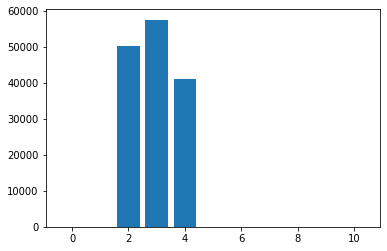

In [ ]:
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
"""# load the dataset
X, y = load_dataset('pima-indians-diabetes.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
"""
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

Feature 0: 0.293292
Feature 1: 0.392809
Feature 2: 50197.061854
Feature 3: 57575.442057
Feature 4: 40979.817157
Feature 5: 0.702942
Feature 6: 0.202854
Feature 7: 0.192411
Feature 8: 0.032333
Feature 9: 0.016217
Feature 10: 0.016217


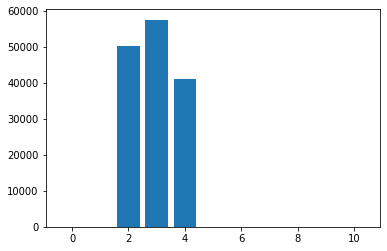

In [ ]:
#feature selection 

def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [ ]:
#https://www.dezyre.com/recipes/select-features-using-best-anova-f-values-in-python

def ProjectPro_Ex_56():
    print()
    print('**How we can select features using best ANOVA F-values in Python**')

    # loading libraries
    from sklearn.datasets import load_iris
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_classif

    # Selecting Features With Best ANOVA F-Values
    # Creating an SelectKBest object to select features with two best ANOVA F-Values
    fvalue_Best = SelectKBest(f_classif, k=5)
    # Applying the SelectKBest object to the features and target
    X_kbest = fvalue_Best.fit_transform(X, y)
    print(X_kbest)

    # Showing results
    print('Original number of features:', X.shape)
    print('Reduced number of features:', X_kbest.shape)
    return X_kbest

result = ProjectPro_Ex_56()
result


**How we can select features using best ANOVA F-values in Python**
[[0.         0.34010152 0.29473684 0.37264151 0.39215686]
 [0.         0.34010152 0.29473684 0.37264151 0.39215686]
 [0.         0.34010152 0.29473684 0.37264151 0.39215686]
 ...
 [1.         0.70050761 0.68421053 0.68396226 0.37254902]
 [1.         0.70050761 0.68421053 0.68396226 0.37254902]
 [1.         0.70050761 0.68421053 0.68396226 0.37254902]]
Original number of features: (35784, 11)
Reduced number of features: (35784, 5)


array([[0.        , 0.34010152, 0.29473684, 0.37264151, 0.39215686],
       [0.        , 0.34010152, 0.29473684, 0.37264151, 0.39215686],
       [0.        , 0.34010152, 0.29473684, 0.37264151, 0.39215686],
       ...,
       [1.        , 0.70050761, 0.68421053, 0.68396226, 0.37254902],
       [1.        , 0.70050761, 0.68421053, 0.68396226, 0.37254902],
       [1.        , 0.70050761, 0.68421053, 0.68396226, 0.37254902]])

In [ ]:
#https://kgptalkie.com/feature-selection-based-on-univariate-anova-test-for-classification-machine-learning-kgp-talkie/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
X.shape, y.shape

((35784, 11), (35784, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1, stratify = y)

In [ ]:
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)
X_train_filter = constant_filter.transform(X_train)
X_test_filter = constant_filter.transform(X_test)

In [ ]:
X_train_filter.shape, X_test_filter.shape

((17892, 11), (17892, 11))

In [ ]:
X_train_T = X_train_filter.T
X_test_T = X_test_filter.T

In [ ]:
X_train_T = pd.DataFrame(X_train_T)
X_test_T = pd.DataFrame(X_test_T)

In [ ]:
X_train_T.duplicated().sum()

0

In [ ]:
duplicated_features = X_train_T.duplicated()

In [ ]:
features_to_keep = [not index for index in duplicated_features]
X_train_unique = X_train_T[features_to_keep].T
X_test_unique = X_test_T[features_to_keep].T

In [ ]:
X_train_unique.shape, X_train.shape

((17892, 11), (17892, 11))

In [ ]:
sel = f_classif(X_train_unique, y_train)
sel

(array([1.56579620e-01, 3.57054103e-01, 3.62278773e+04, 4.16040035e+04,
        2.95416375e+04, 9.41215062e-01, 5.21075844e-01, 3.27348209e-01,
        2.37387347e-01, 1.94728629e+00, 1.94728629e+00]),
 array([0.85506461, 0.69973963, 0.        , 0.        , 0.        ,
        0.39017281, 0.59389029, 0.72083702, 0.78868822, 0.14269092,
        0.14269092]))

In [ ]:
p_values = pd.Series(sel[1])
p_values.index = X_train_unique.columns
p_values.sort_values(ascending = True, inplace = True)

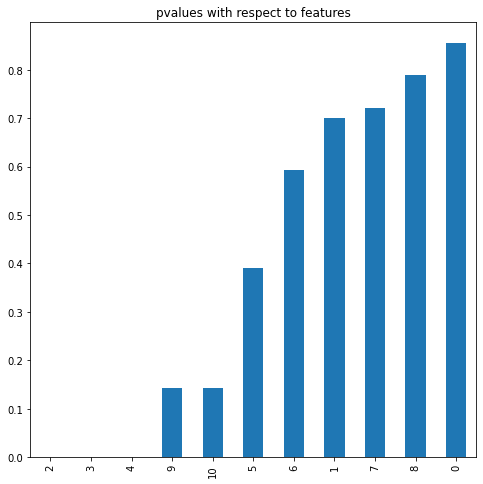

In [ ]:
p_values.plot.bar(figsize = (8, 8))
plt.title('pvalues with respect to features')
plt.show()

In [ ]:
p_values = p_values[p_values<.15]
p_values

2     0.000000
3     0.000000
4     0.000000
9     0.142691
10    0.142691
dtype: float64

In [ ]:
p_values.index

Int64Index([2, 3, 4, 9, 10], dtype='int64')

In [ ]:
X_train_p = X_train_unique[p_values.index]
X_test_p = X_test_unique[p_values.index]

In [ ]:
#https://chrisalbon.com/machine_learning/feature_selection/anova_f-value_for_feature_selection/

# Create an SelectKBest object to select features with six best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k=6)

# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(X, y)

# Show results
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 11
Reduced number of features: 6


In [ ]:
X_kbest

array([[0.        , 0.34010152, 0.29473684, 0.37264151, 0.        ,
        0.39215686],
       [0.        , 0.34010152, 0.29473684, 0.37264151, 0.00635813,
        0.39215686],
       [0.        , 0.34010152, 0.29473684, 0.37264151, 0.05686627,
        0.39215686],
       ...,
       [1.        , 0.70050761, 0.68421053, 0.68396226, 0.38027624,
        0.37254902],
       [1.        , 0.70050761, 0.68421053, 0.68396226, 1.        ,
        0.37254902],
       [1.        , 0.70050761, 0.68421053, 0.68396226, 0.13391269,
        0.37254902]])

# PCA Analysis Below

In [ ]:
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [ ]:
ny = pd.read_csv('./new_york.csv')
ny

,indicator,group,state,subgroup,phase,time_period,time_period_label,time_period_start_date,time_period_end_date,value,lowci,highci,confidence_interval,quartile_range,age,CASE_RATE,HOSPITALIZED_RATE,DEATH_RATE,date,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,counts,sentiment__negative,sentiment__positive
0,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,171.46,13.55,0.23,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
1,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,1554.45,153.69,12.88,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
2,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,2529.03,630.34,113.37,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
3,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,2552.64,1192.50,364.17,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
4,Symptoms of Depressive Disorder,By State,New York,New York,1,1.0,Apr 23 - May 5,2020-04-23T00:00:00.000,2020-05-05T00:00:00.000,28.7,24.6,33.1,24.6 - 33.1,24.1 - 28.7,18 - 29 years,2976.74,1830.07,909.18,2020-04-23,90629.21686,19942.175032,6754.809134,295066.0,500.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35779,Symptoms of Anxiety Disorder or Depressive Dis...,By State,New York,New York,3 (Jan 6 � Feb 1),23.0,Jan 20 - Feb 1,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,32.0 - 39.7,28.8-37.6,80 years and above,20207.72,1160.60,67.68,2021-02-01,224684.00000,13326.000000,794.000000,419169.0,501.0,49.0
35780,Symptoms of Anxiety Disorder or Depressive Dis...,By State,New York,New York,3 (Jan 6 � Feb 1),23.0,Jan 20 - Feb 1,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,32.0 - 39.7,28.8-37.6,80 years and above,15941.19,2540.10,476.51,2021-02-01,161559.00000,25652.000000,4800.000000,419169.0,501.0,49.0
35781,Symptoms of Anxiety Disorder or Depressive Dis...,By State,New York,New York,3 (Jan 6 � Feb 1),23.0,Jan 20 - Feb 1,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,32.0 - 39.7,28.8-37.6,80 years and above,7067.11,2418.35,756.82,2021-02-01,50798.00000,17383.000000,5440.000000,419169.0,501.0,49.0
35782,Symptoms of Anxiety Disorder or Depressive Dis...,By State,New York,New York,3 (Jan 6 � Feb 1),23.0,Jan 20 - Feb 1,2021-01-20T00:00:00.000,2021-02-01T00:00:00.000,35.8,32.0,39.7,32.0 - 39.7,28.8-37.6,80 years and above,7477.43,3995.12,1989.81,2021-02-01,41994.00000,22437.000000,11175.000000,419169.0,501.0,49.0


In [ ]:
ny["indicator"].replace({"Symptoms of Anxiety Disorder": "0", "Symptoms of Depressive Disorder": "1", "Symptoms of Anxiety Disorder or Depressive Disorder": "2"}, inplace=True)
ny["age"].replace({"18 - 29 years": "29", "30 - 39 years": "39", "40 - 49 years": "49", "50 - 59 years":"59","60 - 69 years":"69","70 - 79 years":"79","80 years and above":"80"}, inplace=True)

data_to_use = ny
del data_to_use['group']
del data_to_use['state']
del data_to_use['subgroup']
del data_to_use['time_period_label']
del data_to_use['confidence_interval']
del data_to_use['quartile_range']
del data_to_use['counts']

ny = data_to_use
ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35784 entries, 0 to 35783
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   indicator               35784 non-null  object 
 1   phase                   35784 non-null  object 
 2   time_period             35784 non-null  float64
 3   time_period_start_date  35784 non-null  object 
 4   time_period_end_date    35784 non-null  object 
 5   value                   35784 non-null  float64
 6   lowci                   35784 non-null  float64
 7   highci                  35784 non-null  float64
 8   age                     35784 non-null  object 
 9   CASE_RATE               35784 non-null  float64
 10  HOSPITALIZED_RATE       35784 non-null  float64
 11  DEATH_RATE              33957 non-null  float64
 12  date                    35784 non-null  object 
 13  CASE_COUNT              35784 non-null  float64
 14  HOSPITALIZED_COUNT      35784 non-null

In [ ]:
ny['DEATH_RATE'].fillna((ny['DEATH_RATE'].mean()), inplace=True)
#Add this cell after API change
ny.loc[ny['phase'] == ('Oct 28 � Dec 21'), 'phase'] = 3
ny.loc[ny['phase'] == ('3 (Oct 28 � Dec 21)'), 'phase'] = 4
ny.loc[ny['phase'] == ('3 (Jan 6 � Feb 1)'), 'phase'] = 5
ny.rename(columns = {'counts':'twitter_count'}, inplace = True)

from sklearn import preprocessing

ny["age"] = ny['age'].astype(float)
ny["phase"] = ny['phase'].astype(float)
ny["indicator"] = ny['indicator'].astype(float)
ny["time_period"] = ny['time_period'].astype(float)

In [ ]:
ny = ny[['phase', 'time_period', 'value', 'lowci', 'highci', 'age', 'CASE_RATE', 'HOSPITALIZED_RATE','DEATH_RATE','sentiment__negative', 'sentiment__positive','indicator']]
ny

,phase,time_period,value,lowci,highci,age,CASE_RATE,HOSPITALIZED_RATE,DEATH_RATE,sentiment__negative,sentiment__positive,indicator
0,1.0,1.0,28.7,24.6,33.1,29.0,171.46,13.55,0.23,500.0,50.0,1.0
1,1.0,1.0,28.7,24.6,33.1,29.0,1554.45,153.69,12.88,500.0,50.0,1.0
2,1.0,1.0,28.7,24.6,33.1,29.0,2529.03,630.34,113.37,500.0,50.0,1.0
3,1.0,1.0,28.7,24.6,33.1,29.0,2552.64,1192.50,364.17,500.0,50.0,1.0
4,1.0,1.0,28.7,24.6,33.1,29.0,2976.74,1830.07,909.18,500.0,50.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35779,5.0,23.0,35.8,32.0,39.7,80.0,20207.72,1160.60,67.68,501.0,49.0,2.0
35780,5.0,23.0,35.8,32.0,39.7,80.0,15941.19,2540.10,476.51,501.0,49.0,2.0
35781,5.0,23.0,35.8,32.0,39.7,80.0,7067.11,2418.35,756.82,501.0,49.0,2.0
35782,5.0,23.0,35.8,32.0,39.7,80.0,7477.43,3995.12,1989.81,501.0,49.0,2.0


In [ ]:
cluster_df = ny

In [ ]:
values = ny.values
 
Y = values[:,-1]
X = values[:,0:11]

import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

min_max_scaler = preprocessing.MinMaxScaler()
#x = StandardScaler().fit_transform(x)
x_scaled = StandardScaler().fit_transform(X)
X = pd.DataFrame(x_scaled)

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10
0,-1.046623,-2.028335,-0.519765,-0.617653,-0.412523,-1.574064,-1.255775,-1.196508,-0.878629,-0.078653,0.078653
1,-1.046623,-2.028335,-0.519765,-0.617653,-0.412523,-1.574064,-0.837174,-1.056190,-0.856327,-0.078653,0.078653
2,-1.046623,-2.028335,-0.519765,-0.617653,-0.412523,-1.574064,-0.542190,-0.578936,-0.679167,-0.078653,0.078653
3,-1.046623,-2.028335,-0.519765,-0.617653,-0.412523,-1.574064,-0.535043,-0.016063,-0.237016,-0.078653,0.078653
4,-1.046623,-2.028335,-0.519765,-0.617653,-0.412523,-1.574064,-0.406678,0.622315,0.723818,-0.078653,0.078653
...,...,...,...,...,...,...,...,...,...,...,...
35779,1.655567,1.392188,0.725645,0.752476,0.685975,1.221661,4.808764,-0.048004,-0.759717,0.033034,-0.033034
35780,1.655567,1.392188,0.725645,0.752476,0.685975,1.221661,3.517378,1.333245,-0.038964,0.033034,-0.033034
35781,1.655567,1.392188,0.725645,0.752476,0.685975,1.221661,0.831388,1.211341,0.455212,0.033034,-0.033034
35782,1.655567,1.392188,0.725645,0.752476,0.685975,1.221661,0.955583,2.790110,2.628930,0.033034,-0.033034


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [ ]:
finalDf = pd.concat([principalDf, ny[['indicator']]], axis = 1)

In [ ]:
finalDf

,PC1,PC2,indicator
0,-2.467090,-1.476007,1.0
1,-2.308549,-1.297672,1.0
2,-2.086146,-1.026157,1.0
3,-1.885014,-0.759994,1.0
4,-1.543147,-0.313182,1.0
...,...,...,...
35779,3.236242,1.619092,2.0
35780,3.280442,1.771782,2.0
35781,2.542779,0.998432,2.0
35782,3.296591,1.994987,2.0


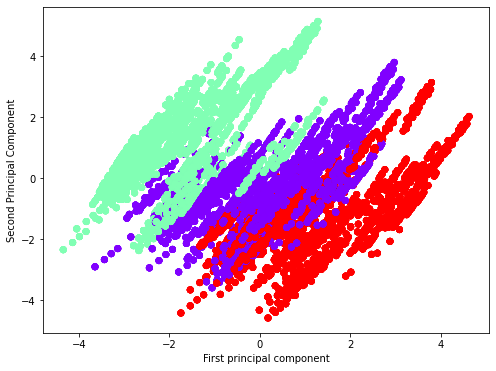

In [ ]:
plt.figure(figsize=(8,6))
targets = ['Anxiety', 'Depression', 'Anxiety or Depression']
plt.scatter(finalDf.iloc[:,0],finalDf.iloc[:,1],
            c=finalDf['indicator'],
            cmap='rainbow'
           )
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
pass;

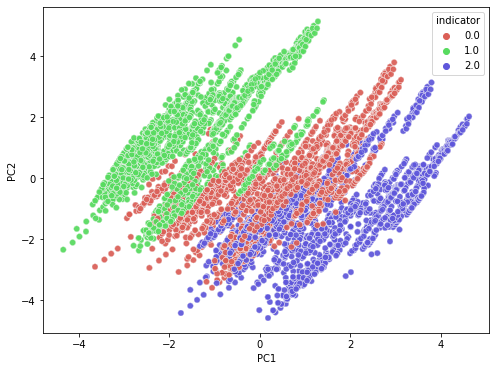

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="indicator",
    palette=sns.color_palette("hls", 3),
    data=finalDf,
    legend="full",
    alpha=0.3
)
pass;

In [ ]:
pca.explained_variance_ratio_

array([0.28677234, 0.2515129 ])

In [ ]:
values = finalDf.values
 
Y = values[:,-1]
X = values[:,0:2]
Y

array([1., 1., 1., ..., 2., 2., 2.])

In [ ]:
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
finalDf2 = finalDf
finalDf3 = finalDf 

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X, Y)
y_kmeans = kmeans.predict(X)

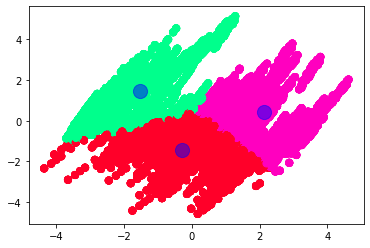

In [ ]:
plt.scatter(finalDf.iloc[:,0], finalDf.iloc[:,1], c=y_kmeans, s=50, cmap='gist_rainbow')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, -1], c='blue', s=200, alpha=0.5);

In [ ]:
finalDf

,PC1,PC2,indicator
0,-2.467090,-1.476007,1.0
1,-2.308549,-1.297672,1.0
2,-2.086146,-1.026157,1.0
3,-1.885014,-0.759994,1.0
4,-1.543147,-0.313182,1.0
...,...,...,...
35779,3.236242,1.619092,2.0
35780,3.280442,1.771782,2.0
35781,2.542779,0.998432,2.0
35782,3.296591,1.994987,2.0


In [ ]:
# K meansfrom sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
# Fit K-Means
kmeans_1 = KMeans(n_clusters=3,random_state= 42)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(cluster_df)
# Calculate cluster validation metrics
score_kemans_s = silhouette_score(cluster_df, kmeans_1.labels_, metric='euclidean')
score_kemans_c = calinski_harabasz_score(cluster_df, kmeans_1.labels_)
score_kemans_d = davies_bouldin_score(cluster_df, predictions)
print('Silhouette Score: %.4f' % score_kemans_s)
print('Calinski Harabasz Score: %.4f' % score_kemans_c)
print('Davies Bouldin Score: %.4f' % score_kemans_d)

Silhouette Score: 0.4987
Calinski Harabasz Score: 70658.2767
Davies Bouldin Score: 0.6646


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

acc = accuracy_score(finalDf.iloc[:,2] , y_kmeans)
print("Accuracy:",accuracy_score(finalDf.iloc[:,2] , y_kmeans))
print(classification_report(finalDf.iloc[:,2] , y_kmeans))
print(confusion_matrix(finalDf.iloc[:,2] , y_kmeans))

Accuracy: 0.6073943661971831
              precision    recall  f1-score   support

         0.0       0.44      0.53      0.48     11928
         1.0       0.89      0.84      0.86     11928
         2.0       0.54      0.45      0.49     11928

    accuracy                           0.61     35784
   macro avg       0.62      0.61      0.61     35784
weighted avg       0.62      0.61      0.61     35784

[[6370 1260 4298]
 [1582 9975  371]
 [6538    0 5390]]


In [ ]:
from scipy.stats import entropy
entropy(y_kmeans)

9.908299663275724

In [ ]:
pd_series = pd.Series(y_kmeans)

counts = pd_series.value_counts()

entropy = entropy(counts)
entropy

1.086523321187857

In [ ]:
finalDf['cluster'] = y_kmeans

In [ ]:
finalDf['indicator'] = finalDf['indicator'] + 1
finalDf['cluster'] = finalDf['cluster'] + 1

In [ ]:
import math
def get_entropys(df_clustered, label_col_name='indicator', cluster_col_name='cluster', cluster_values=range(1,3,1)):
    p = [[round(df_clustered[(df_clustered[label_col_name]==label) & (df_clustered[cluster_col_name]==cluster)].shape[0]/
                df_clustered[df_clustered[cluster_col_name]==cluster].shape[0],3) for label in cluster_values] for cluster in cluster_values]
    p_log_p = [[p_i*math.log(p_i) for p_i in p_i_s if p_i!=0] for p_i_s in p]
    e = [-round(sum(p_log_p_i),3) for p_log_p_i in p_log_p]
    return e
  
entropys_5 = get_entropys(finalDf, label_col_name='indicator', cluster_col_name='cluster', cluster_values=range(1,3,1))
print("Clusters' Entropy")
print("Entropy: {0:.3f}".format(min(entropys_5)))

Clusters' Entropy
Entropy: 0.351


In [ ]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

purity = purity_score(finalDf['indicator'], finalDf['cluster'])
print("The purity is:",purity)

The purity is: 0.6120892018779343


In [ ]:
from sklearn.metrics.cluster import v_measure_score
v_measure = v_measure_score(finalDf['indicator'], finalDf['cluster'])
print("The v_measure is:",v_measure)

The v_measure is: 0.3372524092648669


In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
randScore = adjusted_rand_score(finalDf['indicator'], finalDf['cluster'])
print("The rand_score is:",randScore)

The rand_score is: 0.3100667791309289


In [ ]:
df = finalDf
labels_final = df['indicator'].values
#df = df[:,0:1]
#del df['indicator']
df = df.drop(['indicator'], axis=1)

In [ ]:
finalDf

,PC1,PC2,indicator,cluster
0,-2.467090,-1.476007,2.0,1
1,-2.308549,-1.297672,2.0,1
2,-2.086146,-1.026157,2.0,1
3,-1.885014,-0.759994,2.0,1
4,-1.543147,-0.313182,2.0,1
...,...,...,...,...
35779,3.236242,1.619092,3.0,3
35780,3.280442,1.771782,3.0,3
35781,2.542779,0.998432,3.0,3
35782,3.296591,1.994987,3.0,3


In [ ]:
finalDf.drop(['cluster'], axis=1, inplace=True)
finalDf

,PC1,PC2,indicator
0,-2.467090,-1.476007,2.0
1,-2.308549,-1.297672,2.0
2,-2.086146,-1.026157,2.0
3,-1.885014,-0.759994,2.0
4,-1.543147,-0.313182,2.0
...,...,...,...
35779,3.236242,1.619092,3.0
35780,3.280442,1.771782,3.0
35781,2.542779,0.998432,3.0
35782,3.296591,1.994987,3.0


In [ ]:
#Creating the model
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'complete')
 
#predicting the labels
 
labels = agg_clustering.fit_predict(X,Y)

In [ ]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
finalDf['cluster'] = labels

In [ ]:
print("Accuracy:",accuracy_score(finalDf.iloc[:,2] , labels))
print(classification_report(finalDf.iloc[:,2] , labels))
print(confusion_matrix(finalDf.iloc[:,2] , labels))

Accuracy: 0.3519170579029734
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.40      0.59      0.48     11928
         2.0       1.00      0.47      0.64     11928
         3.0       0.00      0.00      0.00     11928

    accuracy                           0.35     35784
   macro avg       0.35      0.26      0.28     35784
weighted avg       0.47      0.35      0.37     35784

[[   0    0    0    0]
 [4928 6986   14    0]
 [ 294 6027 5607    0]
 [7546 4382    0    0]]


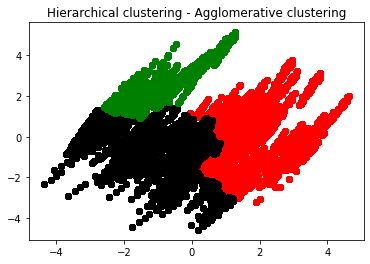

In [ ]:
#filter rows of original data
filtered_label0 = df[labels == 0]
filtered_label1 = df[labels == 1]
filtered_label2 = df[labels == 2]
 
#Plotting the results
plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1] , color = 'red')
plt.scatter(filtered_label1.iloc[:,0] , filtered_label1.iloc[:,1] , color = 'black')
plt.scatter(filtered_label2.iloc[:,0] , filtered_label2.iloc[:,1] , color = 'green')
plt.title("Hierarchical clustering - Agglomerative clustering")
plt.show()

In [ ]:
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram , linkage

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
Z = linkage(df, method = 'complete')
 
"""#plotting dendrogram
dendro = dendrogram(Z)
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()"""

"#plotting dendrogram\ndendro = dendrogram(Z)\nplt.title('Dendrogram')\nplt.ylabel('Euclidean distance')\nplt.show()"

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

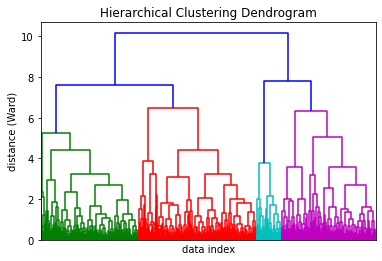

In [ ]:
plt.title('Hierarchical Clustering Dendrogram')
plt.rcParams["figure.figsize"] = (30,20)
# Plot axis labels
plt.xlabel('data index')
plt.xticks([])
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(Z, leaf_rotation=90)
plt.xticks([])
# Show the graph
plt.show()

In [ ]:
score_kemans_s = silhouette_score(finalDf[['PC1','PC2']], labels, metric='euclidean')
score_kemans_c = calinski_harabasz_score(finalDf[['PC1','PC2']], labels)
score_kemans_d = davies_bouldin_score(finalDf[['PC1','PC2']], labels)

print('Silhouette Score: %.4f' % score_kemans_s)
print('Calinski Harabasz Score: %.4f' % score_kemans_c)
print('Davies Bouldin Score: %.4f' % score_kemans_d)

Silhouette Score: 0.3287
Calinski Harabasz Score: 21523.0176
Davies Bouldin Score: 0.9447


In [ ]:
#finalDf['indicator'] = finalDf['indicator'] + 1
finalDf['cluster'] = finalDf['cluster'] + 1

In [ ]:
import math
def get_entropys(df_clustered, label_col_name='indicator', cluster_col_name='cluster', cluster_values=range(1,3,1)):
    p = [[round(df_clustered[(df_clustered[label_col_name]==label) & (df_clustered[cluster_col_name]==cluster)].shape[0]/
                df_clustered[df_clustered[cluster_col_name]==cluster].shape[0],3) for label in cluster_values] for cluster in cluster_values]
    p_log_p = [[p_i*math.log(p_i) for p_i in p_i_s if p_i!=0] for p_i_s in p]
    e = [-round(sum(p_log_p_i),3) for p_log_p_i in p_log_p]
    return e
  
entropys_5 = get_entropys(finalDf, label_col_name='indicator', cluster_col_name='cluster', cluster_values=range(1,3,1))
print("Clusters' Entropy")
print("Entropy: {0:.3f}".format(min(entropys_5)))

Clusters' Entropy
Entropy: 0.454


In [ ]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

purity = purity_score(finalDf['indicator'], finalDf['cluster'])
print("The purity is:",purity)

The purity is: 0.562793427230047


In [ ]:
from sklearn.metrics.cluster import v_measure_score
v_measure = v_measure_score(finalDf['indicator'], finalDf['cluster'])
print("The v_measure is:",v_measure)

The v_measure is: 0.28222970005461184


In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
randScore = adjusted_rand_score(finalDf['indicator'], finalDf['cluster'])
print("The rand_score is:",randScore)

The rand_score is: 0.1732690175823631


In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

22.14995711056769


<Figure size 360x360 with 0 Axes>

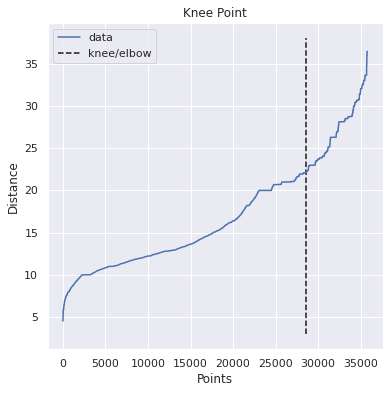

In [ ]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(cluster_df)
distances, indices = neighbors.kneighbors(cluster_df)
distances = np.sort(distances[:,10], axis=0)
!pip install -q kneed
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

Optimal number of min_samples based on silhouette score: [2, 3, 4, 5, 6, 7]


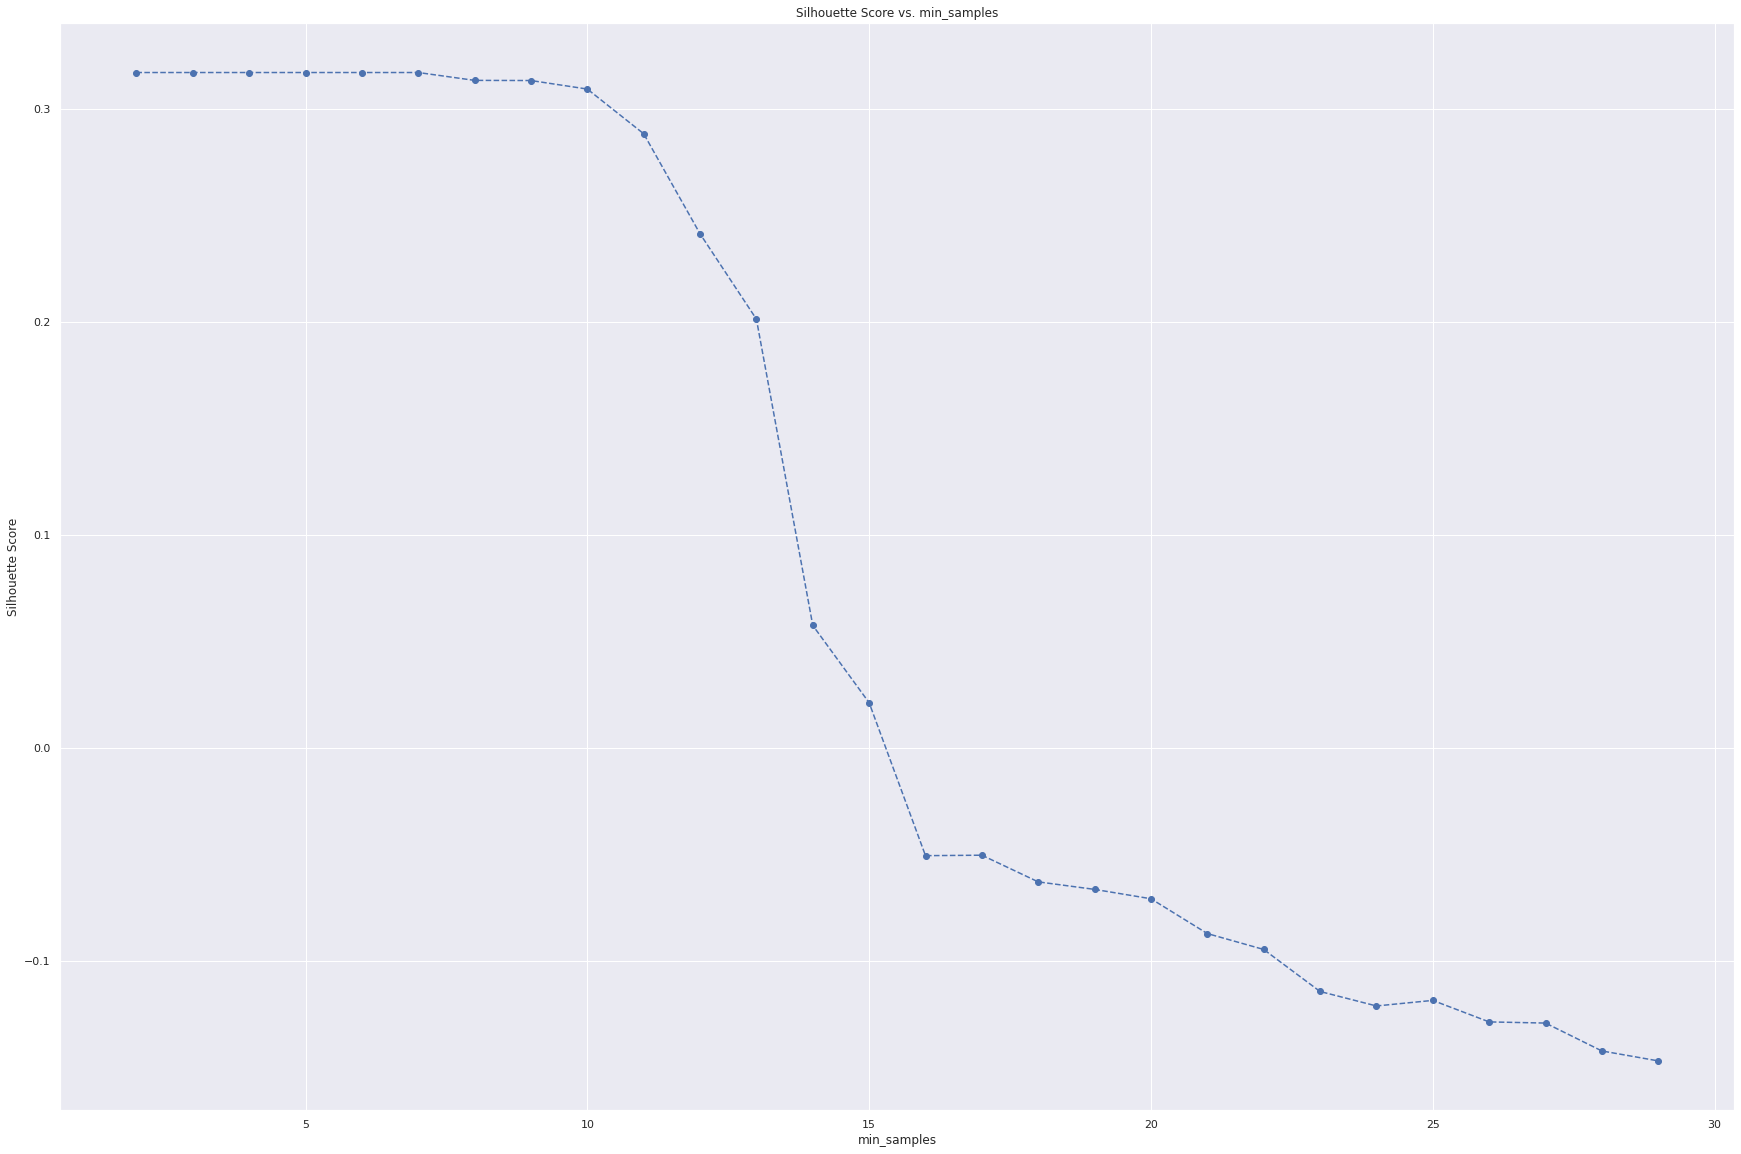

In [ ]:
from sklearn.metrics import silhouette_score 
from sklearn.cluster import DBSCAN

def get_dbscan_score(data, center):
    '''
    
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Silhouette Score for DBSCAN
    '''
    #instantiate kmeans
    dbscan = DBSCAN(eps= 22.14995711056769, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(cluster_df)
    
    # Calculate Silhoutte Score

    score = silhouette_score(cluster_df, model.labels_, metric='euclidean')
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_dbscan_score(cluster_df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_samples');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. min_samples');

df3 = pd.DataFrame(centers,columns=['min_samples'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_samples based on silhouette score:', df4['min_samples'].tolist())

In [ ]:
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
# define dataset
# define the model
model = DBSCAN(eps=22.14995711056769, min_samples= 7)
# rule of thumb for min_samples: 2*len(cluster_df.columns)
# fit model and predict clusters
yhat = model.fit_predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)
# Calculate cluster validation metrics
score_dbsacn_s = silhouette_score(cluster_df, yhat, metric='euclidean')
score_dbsacn_c = calinski_harabasz_score(cluster_df, yhat)
score_dbsacn_d = davies_bouldin_score(cluster_df, yhat)
print('Silhouette Score: %.4f' % score_dbsacn_s)
print('Calinski Harabasz Score: %.4f' % score_dbsacn_c)
print('Davies Bouldin Score: %.4f' % score_dbsacn_d)

Silhouette Score: 0.3172
Calinski Harabasz Score: 139481.4518
Davies Bouldin Score: 0.8524


In [ ]:
cluster_df['yhat'] = yhat + 1

In [ ]:
import math
def get_entropys(df_clustered, label_col_name='indicator', cluster_col_name='cluster', cluster_values=range(1,2,1)):
    p = [[round(df_clustered[(df_clustered[label_col_name]==label) & (df_clustered[cluster_col_name]==cluster)].shape[0]/
                df_clustered[df_clustered[cluster_col_name]==cluster].shape[0],3) for label in cluster_values] for cluster in cluster_values]
    p_log_p = [[p_i*math.log(p_i) for p_i in p_i_s if p_i!=0] for p_i_s in p]
    e = [-round(sum(p_log_p_i),3) for p_log_p_i in p_log_p]
    return e
  
entropys_5 = get_entropys(cluster_df, label_col_name='indicator', cluster_col_name='yhat', cluster_values=range(1,2,1))
print("Clusters' Entropy")
print("Entropy: {0:.3f}".format(min(entropys_5)))

Clusters' Entropy
Entropy: 0.366


In [ ]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

purity = purity_score(finalDf['indicator'], finalDf['cluster'])
print("The purity is:",purity)

The purity is: 0.562793427230047


In [ ]:
from sklearn.metrics.cluster import v_measure_score
v_measure = v_measure_score(finalDf['indicator'], finalDf['cluster'])
print("The v_measure is:",v_measure)

The v_measure is: 0.28222970005461184


In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
randScore = adjusted_rand_score(finalDf['indicator'], finalDf['cluster'])
print("The rand_score is:",randScore)

The rand_score is: 0.1732690175823631


In [ ]:
from sklearn.mixture import GaussianMixture
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        gmm.fit(cluster_df)
        score.append((cov,n_comp,gmm.bic(cluster_df)))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','BIC_Score']
score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]

score_2.head(n=2)

,Covariance_Type,N_Components,BIC_Score
115,full,29,1.264540e+06


In [ ]:
# Silhouette Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov,random_state = 10)
        model = gmm.fit(cluster_df)
        model_2 = model.predict(cluster_df)
        score_s = silhouette_score(cluster_df, model_2, metric='euclidean')
        score.append((cov,n_comp,score_s))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Silhouette_Score']
score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]
score_2.head(n=2)

,Covariance_Type,N_Components,Silhouette_Score
28,tied,2,0.721419
84,full,2,0.721419


In [ ]:
# Calinski Harabasz Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(cluster_df)
        model_2 = model.predict(cluster_df)
        score_c = calinski_harabasz_score(cluster_df, model_2)
        score.append((cov,n_comp,score_c))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Calinski_Harabasz_Score']
score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
score_2.head(n=5)

,Covariance_Type,N_Components,Calinski_Harabasz_Score
27,spherical,29,161101.310169


In [ ]:
# Davies Bouldin Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(cluster_df)
        model_2 = model.predict(cluster_df)
        score_d = davies_bouldin_score(cluster_df, model_2)
        score.append((cov,n_comp,score_d))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Davies_Bouldin_Score']
score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.max()]
score_2.head(n=2)

,Covariance_Type,N_Components,Davies_Bouldin_Score
61,diag,7,9.887544


In [ ]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define the model
model = GaussianMixture(n_components= 29,covariance_type= "full", random_state = 10)
# fit the model
model.fit(cluster_df)
# assign a cluster to each example
yhat = model.predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)



# Calculate cluster validation score

score_dbsacn_s = silhouette_score(cluster_df, yhat, metric='euclidean')

score_dbsacn_c = calinski_harabasz_score(cluster_df, yhat)

score_dbsacn_d = davies_bouldin_score(cluster_df, yhat)



print('Silhouette Score: %.4f' % score_dbsacn_s)
print('Calinski Harabasz Score: %.4f' % score_dbsacn_c)
print('Davies Bouldin Score: %.4f' % score_dbsacn_d)

Silhouette Score: 0.4916
Calinski Harabasz Score: 130511.3962
Davies Bouldin Score: 0.6763


In [ ]:
cluster_df.drop(['yhat'], axis=1, inplace=True)

In [ ]:
cluster_df['yhat2'] = yhat + 1

In [ ]:
import math
def get_entropys(df_clustered, label_col_name='indicator', cluster_col_name='cluster', cluster_values=range(1,4,1)):
    p = [[round(df_clustered[(df_clustered[label_col_name]==label) & (df_clustered[cluster_col_name]==cluster)].shape[0]/
                df_clustered[df_clustered[cluster_col_name]==cluster].shape[0],3) for label in cluster_values] for cluster in cluster_values]
    p_log_p = [[p_i*math.log(p_i) for p_i in p_i_s if p_i!=0] for p_i_s in p]
    e = [-round(sum(p_log_p_i),3) for p_log_p_i in p_log_p]
    return e
  
entropys_5 = get_entropys(cluster_df, label_col_name='indicator', cluster_col_name='yhat2', cluster_values=range(1,3,1))
print("Clusters' Entropy")
print("Entropy: {0:.3f}".format(min(entropys_5)))

Clusters' Entropy
Entropy: 0.732


In [ ]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

purity = purity_score(cluster_df['indicator'], cluster_df['yhat2'])
print("The purity is:",purity)

The purity is: 0.3333333333333333


In [ ]:
from sklearn.metrics.cluster import v_measure_score
v_measure = v_measure_score(finalDf['indicator'], finalDf['cluster'])
print("The v_measure is:",v_measure)

The v_measure is: 0.28222970005461184


In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
randScore = adjusted_rand_score(cluster_df['indicator'], cluster_df['yhat2'])
print("The rand_score is:",randScore)

The rand_score is: -9.792488118189897e-05
